# Lab9 - Spatial Data Analysis
Exploratory spatial data analysis of CitiBike data using pysal and geopandas

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

## Import initial libraries

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pylab as plt

## Working with Shape File

### Loading Census Tract Shape File¶

In [3]:
from geopandas import GeoDataFrame
shape_path="Data/CT_Shape/ct_shape.shp"
ct_shape = GeoDataFrame.from_file(shape_path)
ct_shape.index=ct_shape.BoroCT2010

### Coordinate systems, projections, and transformations 

In [4]:
from fiona.crs import from_epsg
ct_shape.crs = from_epsg(4326) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
NYC_Area=ct_shape.to_crs(epsg=2263).geometry.area.sum()/(2.788*10**7) # from ft2 to mi2 
print ('total NYC land area: %s (mi^2)'%str(NYC_Area)[:5]) # from ft2 to mi2 #epsg=2263 is US feet

total NYC land area: 302.3 (mi^2)


### Visualize the Cencus Tract boundaries colored by boroughs

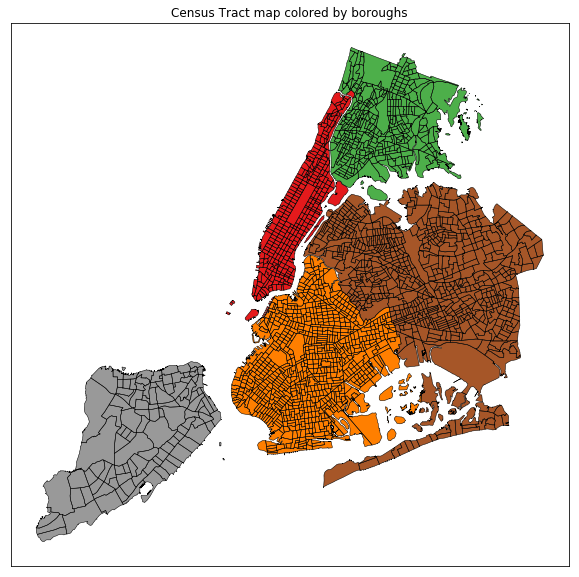

In [5]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape.plot(column='BoroCode',alpha=1,linewidth=0.5,ax=ax)
plt.title("Census Tract map colored by boroughs")

### Map NYC Population density

#### Load Census Data for 2010

In [6]:
ct_data=DataFrame.from_csv('Data/ACS_CT2010.csv')
#set index to be the BoroCT2010 code
ct_data.index=ct_data.BoroCT2010.astype(str)

#### Add popuation density to CT shapefile

In [7]:
ct_shape_pop=ct_shape.join(ct_data[['SE_T002_002']]) #SE_T002_002 is population density in social explorer dataset

#### Vusualize the Population density for 2010

/home/cmp/anaconda2/lib/python2.7/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


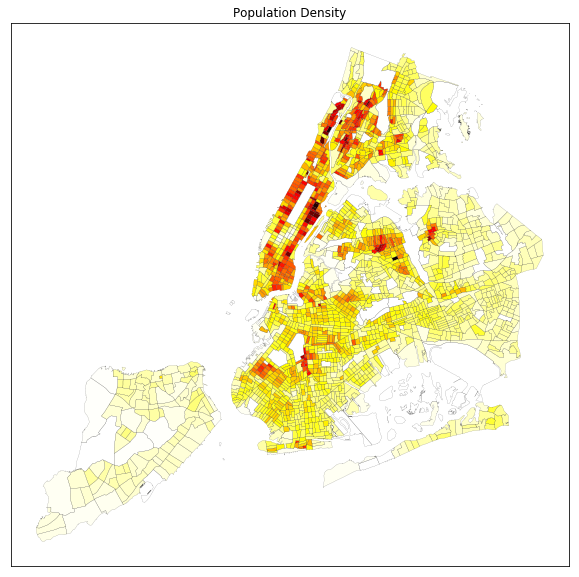

In [8]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_pop.plot(column='SE_T002_002',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Population Density")

## Explore CitiBike data

### Load CitiBike data

In [9]:
df_bike_monthly=DataFrame.from_csv('Data/CitiBike_monthly_byStation.csv')
df_bike_monthly.head()

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2013-07-31,2343,3914,6979,2750,4914,2229,2183,3139,3622,2368,...,0,0,0,0,0,0,0,0,0,0
2013-08-31,2696,4429,9020,3433,6645,2768,2761,3422,4271,2910,...,0,0,0,0,0,0,0,0,0,0
2013-09-30,2878,5258,9814,3739,7837,3206,2747,3590,4618,2885,...,0,0,0,0,0,0,0,0,0,0
2013-10-31,2920,4409,10456,3520,8928,3237,2530,3909,4169,2542,...,0,0,0,0,0,0,0,0,0,0
2013-11-30,1883,2731,6384,2446,5201,2085,1415,2727,3146,1539,...,0,0,0,0,0,0,0,0,0,0


### Time Series Aanalysis

(-200, 16000)

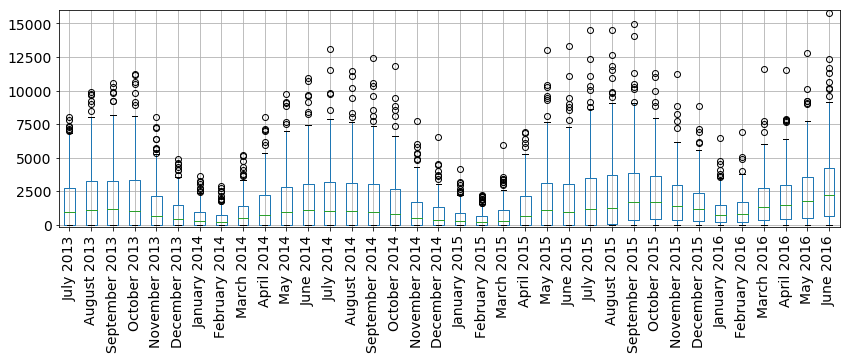

In [10]:
plt.rcParams['font.size']=14
f, ax = plt.subplots(figsize=(14,4))
#create a copy of the df for the viz purposes
df_bike_monthly_=df_bike_monthly.copy()
df_bike_monthly_.index=df_bike_monthly_.index.strftime("%B %Y")
df_bike_monthly_.T.boxplot(figsize=(15,7),ax=ax,rot=90);
ax.set_ylim([-200,16000])

#### Seasonal Decomposition

/home/cmp/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


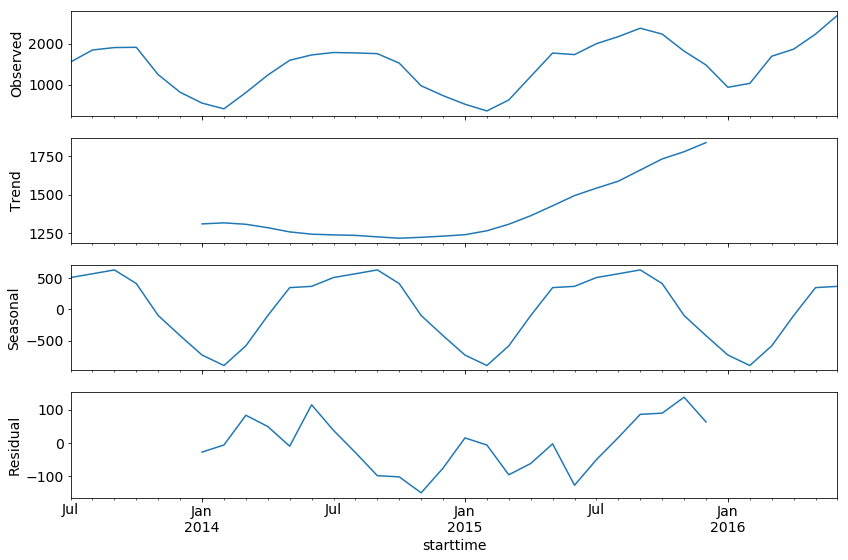

In [11]:
import statsmodels.api as sm

#Create a monthly time series of bike ride (Average of all citibike stations)
df_new=df_bike_monthly.mean(1).resample('M').mean()
df_new.interpolate(inplace=True)

#Seasonal Decomposition using statsmodels api
res = sm.tsa.seasonal_decompose(df_new.dropna())
plt.rcParams['figure.figsize']=(12,8)
resplot = res.plot()

## Map CitiBike Data to CT level

### Load CitiBike station location data

In [12]:
station_id=DataFrame.from_csv('Data/Station_id.csv')
#convert station_ids to string index
station_id.index=station_id.index.astype(str)
station_id.head()

,lat,lon
1000,40.753231,-73.970325
1001,40.749718,-74.002950
1002,40.730287,-73.990765
1003,40.718939,-73.992663
1004,40.734927,-73.992005


### Create CitiBike station Geometry (Point) from Corrdinates (Lat & Lon)

In [13]:
import shapely
# combine lat and lon to one column
station_id['lonlat']=zip(station_id.lon,station_id.lat)
# Create Point Geometry for based on lonlat column
station_id['geometry']=station_id[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
station_id.head()

,lat,lon,lonlat,geometry
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098)
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753)
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666)
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904)
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695)


### Intersect the two geometries

In [14]:
a=[]
# check for each citibike stations to see what CT they are belong to
for i in range(len(station_id)):
    a.append(ct_shape[ct_shape.geometry.intersects(station_id.iloc[i].geometry)].BoroCT2010.values[0])
    print '\r',"%",str((i+1)*100./len(station_id))[:4],
station_id['BoroCT2010']=a

% 100.            40.8                  


In [15]:
import geopandas as gpd

In [16]:
station_id = GeoDataFrame(station_id)

In [26]:
station_id.crs = from_epsg(4326)
ct_shape.crs

{'init': 'epsg:4326', 'no_defs': True}

In [22]:
station_ft = station_id.to_crs(epsg=2263)
ct_ft = ct_shape.to_crs(epsg=2263)

In [32]:
ct_ft.reset_index(drop=True)

,BoroCT2010,BoroCode,BoroName,CDEligibil,CT2010,CTLabel,NTACode,NTAName,PUMA,Shape_Area,Shape_Leng,geometry
0,5000900,5,Staten Island,I,000900,9,SI22,West New Brighton-New Brighton-St. George,3903,2.497010e+06,7729.016729,"POLYGON ((962269.1260375973 173705.5001830472,..."
1,5012500,5,Staten Island,I,012500,125,SI22,West New Brighton-New Brighton-St. George,3903,4.954936e+06,10582.855530,"POLYGON ((951998.5532226549 168438.0043944769,..."
2,5013301,5,Staten Island,E,013301,133.01,SI22,West New Brighton-New Brighton-St. George,3903,7.217847e+05,3428.312676,"POLYGON ((951720.9486083974 170488.4069823704,..."
3,5019700,5,Staten Island,I,019700,197,SI07,Westerleigh,3903,3.231720e+06,9097.697226,"POLYGON ((947819.2308349615 164190.0209960272,..."
4,5002002,5,Staten Island,I,002002,20.02,SI14,Grasmere-Arrochar-Ft. Wadsworth,3902,8.501224e+06,12591.725901,"POLYGON ((966615.2556152344 158662.2927855851,..."
5,5006400,5,Staten Island,I,006400,64,SI14,Grasmere-Arrochar-Ft. Wadsworth,3902,7.643184e+06,12726.360406,"POLYGON ((963023.8917846683 158246.7521972115,..."
6,5007400,5,Staten Island,I,007400,74,SI14,Grasmere-Arrochar-Ft. Wadsworth,3902,5.788238e+06,9902.948475,"POLYGON ((967656.8290405255 155637.1314086207,..."
7,5018701,5,Staten Island,I,018701,187.01,SI07,Westerleigh,3903,4.267476e+06,8626.771269,"POLYGON ((950555.9412231392 161453.6582030659,..."
8,1002202,1,Manhattan,I,002202,22.02,MN28,Lower East Side,3809,6.039223e+05,3817.391631,"POLYGON ((990284.3284301723 201838.3563842234,..."
9,1003200,1,Manhattan,I,003200,32,MN22,East Village,3809,2.334190e+06,6358.386684,"POLYGON ((989819.2963867191 204093.9949950601,..."


In [33]:
gpd.sjoin(ct_ft.reset_index(drop=True), station_ft)

ArgumentError: argument 2: <type 'exceptions.TypeError'>: wrong type

In [ ]:
ct_shape.reset_index(drop=True)

In [ ]:
gpd.sjoin(station_id1, ct_shape)

In [ ]:
gpd.sjoin(station_id1, ct_shape)

In [ ]:
station_id.BoroCT2010.head()

### Add Monthly rides to the station GeoDataFrame with CT code

In [ ]:
### Create average monthly rides column from monthly citibike data and add it to the station id which has the geometry
station_id['MonthlyAve']=df_bike_monthly.sum()

In [ ]:
station_id.head()

### Add the monthly average rides to the CT shapefile 

In [ ]:
# use the 
temp=station_id[['MonthlyAve']]
temp['station_id']=station_id.index
temp.index=station_id['BoroCT2010']
ct_shape_MonthlyAve=ct_shape.join(temp)
ct_shape_MonthlyAve.fillna(0,inplace=True)

In [ ]:
f, ax = plt.subplots(figsize=(10,10))
ct_shape_MonthlyAve.plot(column='MonthlyAve',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Monthly Ride Counts")

### Removing the CTs that are out of zoom boundries

In [ ]:
ct_shape_MonthlyAve_Zoom=(ct_shape_MonthlyAve[ct_shape_MonthlyAve
                           .centroid
                           .apply(lambda c:c.x>-74.1 and c.x<-73.92 and c.y>40.65 and c.y<40.8)])

In [ ]:
print "Total number of CTs:", len(ct_shape)
print "Number of zoomed CTs:", len(temp.MonthlyAve)

### Map the monthly rides 

In [ ]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_MonthlyAve_Zoom.plot(column='MonthlyAve',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Monthly Ride Counts")

### Export Shapefile CTs in the CitiBike Zone

In [ ]:
path='Output/ct_shape_MonthlyAve_Zoom.shp'
ct_shape_MonthlyAve_Zoom.to_file(path)

## Exploratory Geospatial Analysis

In [ ]:
import pysal as ps

### Spatial Weights
Contiguity: Queen Weights

In [ ]:
qW_CT=ps.queen_from_shapefile(path)

#### Neighbors of index10

In [ ]:
qW_CT[10]

In [ ]:
qW_CT.cardinalities[10]

#### Matrix of Weights

In [ ]:
Wmatrix, ids = qW_CT.full()

In [ ]:
Wmatrix

#### Change the matrix to be row-standardized

In [ ]:
qW_CT.transform = 'r'

### Spatial Lag  
Similarity of CT neibors can be meseard by means of spatial lag as follow:
$$BikeRideCountLag = \sum_j w_{i,j} BikeRideCount$$

In [ ]:
MonthlyRide=ct_shape_MonthlyAve_Zoom.MonthlyAve
MonthlyRideLag=ps.lag_spatial(qW_CT, MonthlyRide)

#### Create Quantiles for maping

In [ ]:
MonthlyRideLagQ10 = ps.Quantiles(MonthlyRideLag, k=10)
MonthlyRideLagQ10

#### Map the monthly rides lag

In [ ]:
f, ax = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAve_Zoom.assign(cl=MonthlyRideLagQ10.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Monthly Ride Spatial Lag Deciles")


## Global  Spatial Autocorrelation

In [ ]:
b,a = np.polyfit(MonthlyRide, MonthlyRideLag, 1)
b,a 

### Moran Scatterplot

In [ ]:
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(MonthlyRide, MonthlyRideLag, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
plt.vlines(MonthlyRide.mean(), MonthlyRideLag.min(), MonthlyRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(MonthlyRideLag.mean(), MonthlyRide.min(), MonthlyRide.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(MonthlyRide, a + b*MonthlyRide, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of MonthlyRides')
plt.xlabel('MonthlyRides')

### Moran's I

In [ ]:
I_MonthlyRide = ps.Moran(MonthlyRide, qW_CT)

In [ ]:
I_MonthlyRide.I, I_MonthlyRide.p_sim

Thus, the $I$ statistic is $0.656$ for this data, and has a very small $p$ value. 

In [ ]:
I_MonthlyRide.sim[0:10]

### KDEplot of all of the simulated points
the vertical line shows the observed value

In [ ]:
import seaborn as sns
plt.rcParams['figure.figsize']=(14,3)

In [ ]:
sns.kdeplot(I_MonthlyRide.sim, shade=True)
plt.vlines(I_MonthlyRide.sim, 0, 1)
plt.vlines(I_MonthlyRide.I, 0, 10, 'r')
plt.xlim([-.70, .70])

In the following figure the vertical line is showing if our $I$ statistic were close to our expected value

In [ ]:
sns.kdeplot(I_MonthlyRide.sim, shade=True)
plt.vlines(I_MonthlyRide.sim, 0, 1)
plt.vlines(I_MonthlyRide.EI+.01, 0, 10, 'r')
plt.xlim([-.70, .70])

## Local  Spatial Autocorrelation

In [ ]:
LMo_MonthlyRide = ps.Moran_Local(MonthlyRide, qW_CT,permutations=999)

In [ ]:
LMo_MonthlyRide.Is[0:5], LMo_MonthlyRide.p_sim[0:5]

### LISA (Local Indicators of Spatial Autocorrelation)

In [ ]:
sigs = MonthlyRide[LMo_MonthlyRide.p_sim <= .001]
W_sigs = MonthlyRideLag[LMo_MonthlyRide.p_sim <= .001]
insigs = MonthlyRide[LMo_MonthlyRide.p_sim > .001]
W_insigs = MonthlyRideLag[LMo_MonthlyRide.p_sim > .001]

### Plot Signficant LISA

In [ ]:
f, ax = plt.subplots(figsize=(9, 9))
plt.plot(sigs, W_sigs, '.', color='firebrick')
plt.plot(insigs, W_insigs, '.k', alpha=.2)
plt.text(s='$I = %.3f$' % I_MonthlyRide.I, x=120000, y=5000, fontsize=18)

 # dashed vert at mean of the last year's PCI
plt.vlines(MonthlyRide.mean(), MonthlyRideLag.min(), MonthlyRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(MonthlyRideLag.mean(), MonthlyRide.min(), MonthlyRide.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(MonthlyRide, a + b*MonthlyRide, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of MonthlyRides')
plt.xlabel('MonthlyRides')


### Hot and Cold spots 

In [ ]:
sig = LMo_MonthlyRide.p_sim < 0.01
hotspots = LMo_MonthlyRide.q==1 * sig
coldspots = LMo_MonthlyRide.q==3 * sig
print "Number of Hotspots:", hotspots.sum()
print "Number of Coldspots:", coldspots.sum()

In [ ]:
from matplotlib import colors

hcmap = colors.ListedColormap(['grey','red','blue'])
hotcold = hotspots*1 + coldspots*2

f, ax = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAve_Zoom.assign(cl=hotcold).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap, linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("MonthlyAve Spatial Lag Deciles")